In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F

In [9]:
data_set = pd.read_csv("shoot_data_set_modified.csv")
data_set.drop(data_set[data_set.Result == 'OwnGoal'].index, inplace=True)

data_set['LastAction'].replace({"Card":"None", "Error":"None", "ChanceMissed":"None", "FormationChange":"None", "Goal":"None", "GoodSkill":"None", "KeeperPickup":"None", "KeeperSweeper":"None", "OffsideProvoked":"None", "ShieldBallOpp":"None", "SubstitutionOff":"None", "SubstitutionOn":"None"}, inplace=True)
data_set['LastAction'].replace({"BlockedPass":"BallRecovery","Dispossessed":"BallRecovery","Smother":"BallRecovery","Tackle":"BallRecovery", "Interception":"BallRecovery"},inplace=True)
data_set['LastAction'].replace({"Challenge":"BallTouch"},inplace=True)
data_set['LastAction'].replace({"Clearance":"Rebound", "Punch":"Rebound", "Save":"Rebound"},inplace=True)
data_set['LastAction'].replace({"CornerAwarded":"SetPiece", "End":"SetPiece", "Foul":"SetPiece", "OffsidePass":"SetPiece", "Standard":"SetPiece", "Start":"SetPiece"},inplace=True)

In [11]:
y = np.array([1 if result == 'Goal' else 0 for result in data_set['Result']])

In [12]:
xG_values = one_hot_encoded_data['xG']

In [22]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(0)


import os
from pathlib import Path
import shutil
import gzip

from matplotlib import pyplot as plt
%matplotlib inline

In [24]:
n_total = len(data_set)

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)

In [26]:
categorical_columns = []
categorical_dims =  {}
train = data_set.copy()
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

Situation 5
LastAction 13
ShotType 4
Result 5


In [28]:
train = train.drop("xG")

KeyError: "['xG'] not found in axis"

In [31]:
train = train.drop('xG',1)

In [32]:
train = train.drop('Result',1)

In [33]:
unused_feat = []

features = [ col for col in train.columns if col not in unused_feat] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [41]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15,
    verbose=5,
)

Device used : cpu


In [37]:
X_train = train[features].values[train_indices]
y_train = y[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = y[valid_indices]

X_test = train[features].values[test_indices]
y_test = y[test_indices]

In [42]:
max_epochs = 100

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=256,
) 

epoch 0  | loss: 0.76808 | train_auc: 0.48457 | valid_auc: 0.49261 |  0:01:21s
epoch 5  | loss: 0.27611 | train_auc: 0.46069 | valid_auc: 0.45939 |  0:05:56s
epoch 10 | loss: 0.2728  | train_auc: 0.51843 | valid_auc: 0.51604 |  0:09:42s
epoch 15 | loss: 0.27195 | train_auc: 0.60918 | valid_auc: 0.60609 |  0:13:42s
epoch 20 | loss: 0.27132 | train_auc: 0.6281  | valid_auc: 0.62568 |  0:17:41s
epoch 25 | loss: 0.27222 | train_auc: 0.66787 | valid_auc: 0.66345 |  0:21:45s
epoch 30 | loss: 0.27396 | train_auc: 0.71616 | valid_auc: 0.71407 |  0:25:57s
epoch 35 | loss: 0.26982 | train_auc: 0.74603 | valid_auc: 0.74361 |  0:29:50s
epoch 40 | loss: 0.26899 | train_auc: 0.76785 | valid_auc: 0.76509 |  0:33:25s
epoch 45 | loss: 0.27011 | train_auc: 0.78301 | valid_auc: 0.77989 |  0:37:01s
epoch 50 | loss: 0.26928 | train_auc: 0.80048 | valid_auc: 0.79771 |  0:40:36s
epoch 55 | loss: 0.27    | train_auc: 0.80362 | valid_auc: 0.79938 |  0:44:09s
epoch 60 | loss: 0.26831 | train_auc: 0.80625 | vali

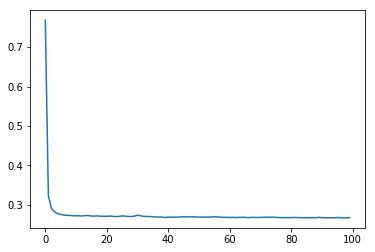

In [70]:
plt.plot(clf.history['loss'])


In [71]:
saved_filename = clf.save_model('test')

TypeError: Object of type int32 is not JSON serializable

In [48]:
# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

KeyError: 'train_accuracy'

In [51]:
# To get final results you may need to use a mapping for classes 
# as you are allowed to use targets like ["yes", "no", "maybe", "I don't know"]

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE FOR : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR  : {test_acc}")

BEST VALID SCORE FOR : 0.8071070637543962
FINAL TEST SCORE FOR  : 0.9034440133228033


In [75]:
print(clf)

TabNetClassifier(n_d=64, n_a=64, n_steps=5, gamma=1.5, cat_idxs=[0, 1, 4], cat_dims=[5, 13, 4], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.3, lambda_sparse=0.0001, seed=0, clip_value=2.0, verbose=5, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'gamma': 0.95, 'step_size': 20}, mask_type='sparsemax', input_dim=5, output_dim=2, device_name='auto')


In [76]:
saved_filename = clf.save_model('test_model')

TypeError: Object of type int32 is not JSON serializable

In [57]:
preds[:,0]

array([0.47893   , 0.79890835, 0.9373778 , ..., 0.9314818 , 0.57791364,
       0.9756374 ], dtype=float32)

In [54]:
y_test_xg = xG_values.values[test_indices]

In [68]:
error = abs((preds[:,1]-y_test_xg)).mean()

In [67]:
print(error)

0.04582069666362248


In [63]:
preds.shape

(58246, 2)

In [64]:
y_test_xg.shape

(58246,)

In [65]:
preds

array([[0.47893   , 0.52107006],
       [0.79890835, 0.20109168],
       [0.9373778 , 0.06262216],
       ...,
       [0.9314818 , 0.06851822],
       [0.57791364, 0.42208633],
       [0.9756374 , 0.02436259]], dtype=float32)

In [66]:
y_test_xg

array([0.14870517, 0.30227497, 0.05221085, ..., 0.03875686, 0.48749644,
       0.02077757])